In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_path = "data/test_image1.jpeg"

In [3]:
image = cv2.imread(image_path)
plt.imshow(image)
print('Image Shape', image.shape)

Image Shape (1442, 1756, 3)


## Experiment with different Blur techniques and the Canny edge detection
- Blur detection algorithms considered: box, gaussian and median
- Gaussian Blur performs the best and gives very natural boundaries later with edge detection. Possibly due to the way images are clicked as well, the center of attention pixel is sharper while blurring out pixels as we move away.

In [4]:
def plot_images(images, titles=None):
    """
    Function to plot multiple images in a grid with 3 images per row using matplotlib.
    
    Parameters:
    - images (list): List of image variables (in OpenCV format, i.e., BGR).
    - titles (list, optional): List of titles for the images.
    """
    # Calculate number of rows and columns based on number of images
    num_images = len(images)
    cols = 3
    rows = (num_images + cols - 1) // cols  # Round up the number of rows if not divisible by 3
    
    # Create a figure with the appropriate number of rows and columns
    plt.figure(figsize=(15, 5 * rows))  # Adjust the figure size to accommodate the images

    for i, image in enumerate(images):
        # Convert BGR to RGB (OpenCV loads images in BGR format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create a subplot for each image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_rgb)
        if titles:
            plt.title(titles[i])
        plt.axis('off')  # Hide axes

    # If the number of images is not divisible by 3, remove unused subplots
    for i in range(num_images, rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')  # Hide empty subplots

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

def preprocess_image(image_path):
    """
    Preprocess the image for text detection.
    Converts to grayscale, removes noise, and applies edge detection.
    """
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Remove noise using GaussianBlur
    gaussian_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    median_blurred = cv2.medianBlur(gray, 5, 0)
    box_blurred = cv2.blur(gray, (5,5))
    
    # Apply edge detection
    edges = cv2.Canny(gaussian_blurred, 50, 150)
    
    return image, gray, gaussian_blurred, median_blurred, box_blurred, edges

# Example usage
original_image, gray_image, gaussian_blurred_image, median_blurred_image, box_blurred_image,  edges_image = preprocess_image(image_path)

# Save intermediate outputs for visualization
cv2.imwrite("output/gray_image.png", gray_image)
cv2.imwrite("output/gaussian_blurred_image.png", gaussian_blurred_image)
cv2.imwrite("output/median_blurred_image.png", median_blurred_image)
cv2.imwrite("output/box_blurred_image.png", box_blurred_image)
cv2.imwrite("output/edges_image.png", edges_image)

True

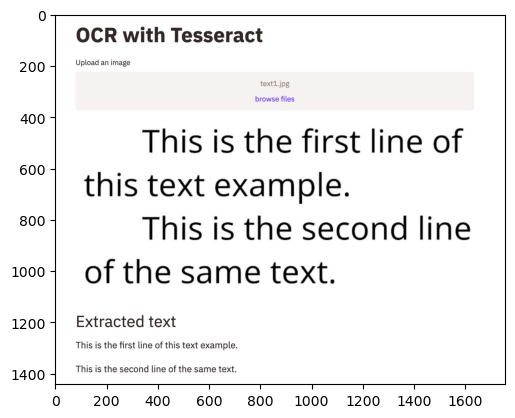

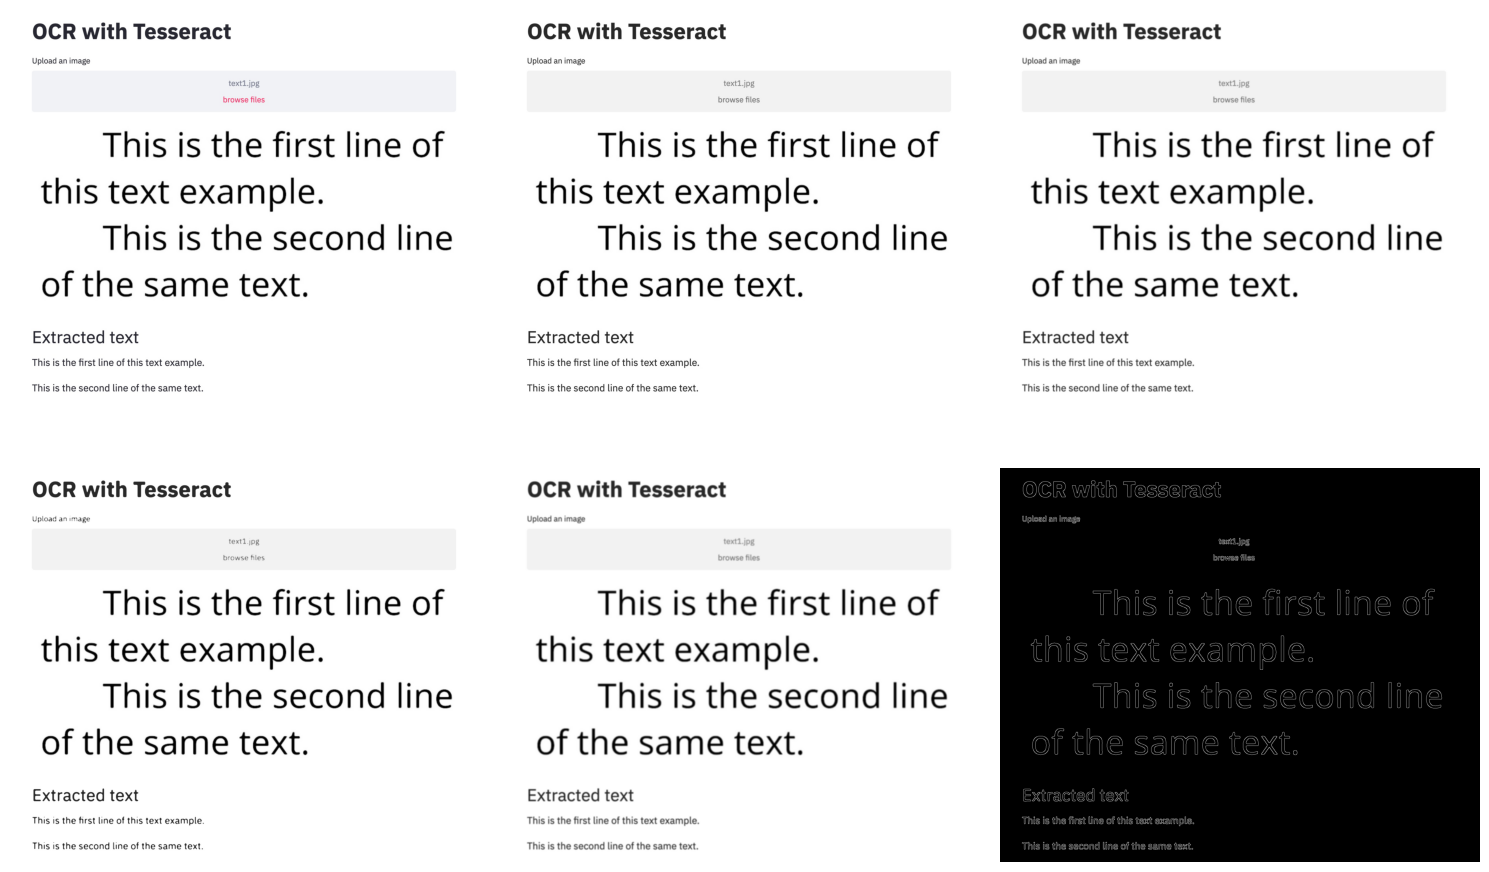

In [5]:
plot_images([original_image, gray_image, gaussian_blurred_image, median_blurred_image, box_blurred_image,  edges_image])

## Trying to understand Canny Algorithm by coding individual steps
### Step 1: Apply Sobel Operator in 2 directions to understand the sharp gradient presence
- Use kernel to get x & y direction magnitudes
- Take root of sum of squares to get magnitude
- Take arctan2 to get the angle

In [6]:
def apply_kernel(image, kernel):
    """Apply a kernel to an image using convolution."""
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    padded_image = np.pad(image, pad_width=((kernel_height // 2, kernel_height // 2), 
                                            (kernel_width // 2, kernel_width // 2)), mode='constant', constant_values=0)
    result = np.zeros_like(image)
    
    for i in range(image_height):
        for j in range(image_width):
            result[i, j] = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)
    
    return result
    
def sobel_operator(image):
    """Apply Sobel operator to detect edges."""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    grad_x = apply_kernel(image, sobel_x)
    grad_y = apply_kernel(image, sobel_y)
    
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_direction = np.arctan2(grad_y, grad_x)
    
    return [grad_x, grad_y, gradient_magnitude, gradient_direction]

In [7]:
grad_x, grad_y, gradient_magnitude, gradient_direction = sobel_operator(gaussian_blurred_image)
print("Shape of gradient_magnitude vector", gradient_magnitude.shape)
print("Shape of gradient_direction vector", gradient_direction.shape)
cv2.imwrite("output/gradient_magnitude.png", gradient_magnitude)
cv2.imwrite("output/gradient_direction.png", gradient_direction)

Shape of gradient_magnitude vector (1442, 1756)
Shape of gradient_direction vector (1442, 1756)


True

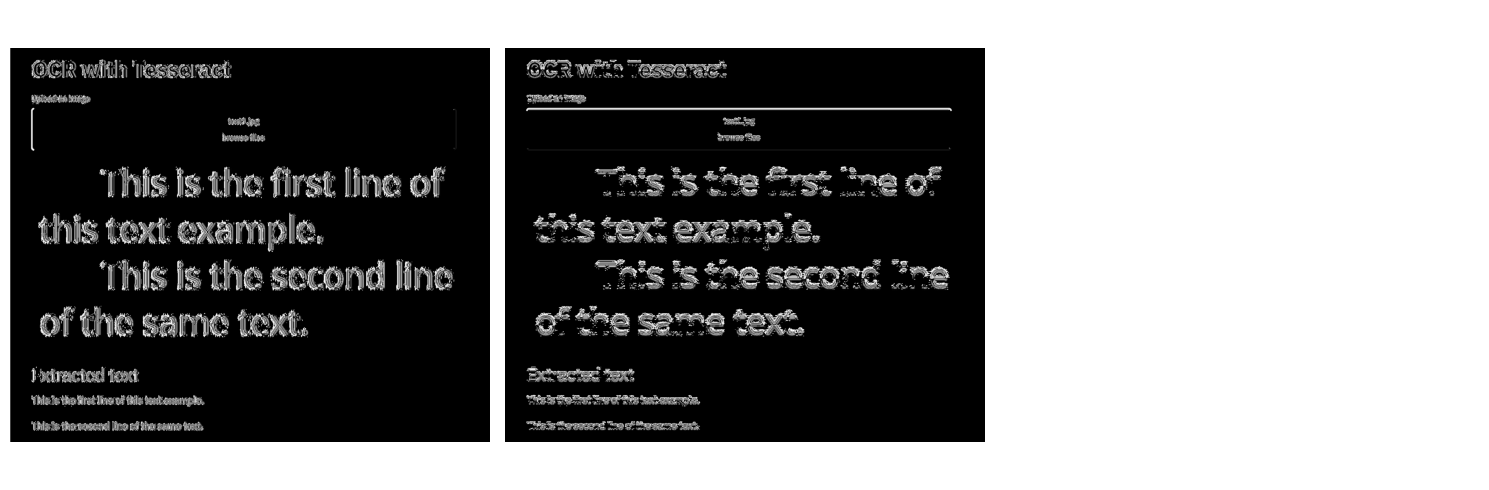

True

In [8]:
#Plotting gradient x and y
plot_images([grad_x, grad_y])
cv2.imwrite("output/grad_x.png", grad_x)
cv2.imwrite("output/grad_y.png", grad_y)

### Step 2: Non maximum suppression
- Thin out the edges by suppressing now local maxima (done by comapring with the 2 neighbours in the appropriate directions)
- Local maxima in the gradient direction are kept

In [9]:
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    """Apply non-maximum suppression to thin out the edges."""
    height, width = gradient_magnitude.shape
    suppressed_image = np.zeros_like(gradient_magnitude)
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            angle = gradient_direction[i, j] * 180.0 / np.pi
            if angle < 0:
                angle += 180

            # Horizontal edge (0 degrees)
            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                neighbor1 = gradient_magnitude[i, j-1]
                neighbor2 = gradient_magnitude[i, j+1]
            # Diagonal edge (45 degrees)
            elif (22.5 <= angle < 67.5):
                neighbor1 = gradient_magnitude[i-1, j+1]
                neighbor2 = gradient_magnitude[i+1, j-1]
            # Vertical edge (90 degrees)
            elif (67.5 <= angle < 112.5):
                neighbor1 = gradient_magnitude[i-1, j]
                neighbor2 = gradient_magnitude[i+1, j]
            # Diagonal edge (135 degrees)
            else:
                neighbor1 = gradient_magnitude[i-1, j-1]
                neighbor2 = gradient_magnitude[i+1, j+1]
            
            if gradient_magnitude[i, j] >= neighbor1 and gradient_magnitude[i, j] >= neighbor2:
                suppressed_image[i, j] = gradient_magnitude[i, j]
            else:
                suppressed_image[i, j] = 0
    
    return suppressed_image

In [10]:
%time
suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)
print("Shape of suppressed_image vector", suppressed_image.shape)
cv2.imwrite("output/suppressed_image.png", suppressed_image)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 5.25 μs
Shape of suppressed_image vector (1442, 1756)


True

### Step 3: Double Thresholding
- Classify edges to strong, weak or non-edges
- Strong Edge is set to white(255), weak to gray(1) and non-edge to black(0)

In [11]:
def double_thresholding(image, low_threshold, high_threshold):
    """Apply double thresholding."""
    strong_edges = np.zeros_like(image)
    weak_edges = np.zeros_like(image)

    strong_edges[image >= high_threshold] = 255
    weak_edges[(image >= low_threshold) & (image < high_threshold)] = 1

    return strong_edges, weak_edges

In [12]:
%time
low_threshold = 50        
high_threshold = 150 
strong_edges, weak_edges = double_thresholding(suppressed_image, low_threshold, high_threshold)
print("Shape of strong_edges vector", strong_edges.shape)
print("Shape of weak_edges vector", weak_edges.shape)
cv2.imwrite("output/strong_edges.png", strong_edges)
cv2.imwrite("output/weak_edges.png", weak_edges)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.86 μs
Shape of strong_edges vector (1442, 1756)
Shape of weak_edges vector (1442, 1756)


True

### Step 4: Edge tracking by hysteris
- Weak edges connected to strong edges are checked
- Weak edges with connection are kept

In [13]:
def edge_tracking_by_hysteresis(strong_edges, weak_edges):
    """Track weak edges that are connected to strong edges."""
    height, width = strong_edges.shape
    final_edges = np.copy(strong_edges)

    for i in range(1, height-1):
        for j in range(1, width-1):
            if weak_edges[i, j] == 1:
                # Check if weak edge is connected to any strong edge
                if (strong_edges[i-1:i+2, j-1:j+2] == 255).any():
                    final_edges[i, j] = 255
                else:
                    final_edges[i, j] = 0

    return final_edges

In [14]:
%time
result = edge_tracking_by_hysteresis(strong_edges, weak_edges)

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 2.62 μs


In [15]:
result.shape

(1442, 1756)

In [16]:
cv2.imwrite("output/edges.png", result)

True